# Radio Telemetry Tracker - Localization Estimation/Precision
This notebooks details the math and code for localization estimation and precision estimation

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

# Model Estimation
To determine the location of the radio transmitter, we need to find a relationship between the measurement location and the radio amplitude measurement.  We use the radio signal path loss model: $L = 10nlog_{10}(d)$.

We can then rewrite this in terms of receive and transmit power, $R$ and $P$: $R = P - 10nlog_{10}(d) + C$, where $C$ represents receiver losses not due to path loss.

In theory, the power order $n$ is 2 for path loss in a vacuum, but in practice, we see $n$ range from $2$ to $6$.

However, we cannot in principle differentiate between P and C, as they are summed together, so we can simply combine them into a single parameter $k$: $R = k - 10nlog_{10}(d)$

In [2]:
def distance_to_receive_power(distance: float, k: float, order: float) -> float:
    return k - 10 * order * np.log10(distance)

When we receive data, we can extract the following information: drone location in x, y, and z, and transmitter receive power.  We can then put this information into a matrix $D = \begin{bmatrix}x_d & y_d & z_d & R\end{bmatrix}$, where $x_d$ is the column vector of drone x coordinates, $y_d$ is the column vector of drone y coordinates, $z_d$ is the column vector of drone z coordinates, and $R$ is the column vector of receive powers.  We generate a simulated dataset below:

[[ -95.            1.           30.           19.06451458]
 [ -90.            2.           30.           19.91129027]
 [ -85.            3.           30.           20.79391664]
 [ -80.            4.           30.           21.71452606]
 [ -75.            5.           30.           22.675174  ]
 [ -70.            6.           30.           23.67769434]
 [ -65.            7.           30.           24.72347151]
 [ -60.            8.           30.           25.81308729]
 [ -55.            9.           30.           26.9457811 ]
 [ -50.           10.           30.           28.11863911]
 [ -45.           11.           30.           29.32540202]
 [ -40.           12.           30.           30.55477098]
 [ -35.           13.           30.           31.78813173]
 [ -30.           14.           30.           32.99678926]
 [ -25.           15.           30.           34.13923903]
 [ -20.           16.           30.           35.15980815]
 [ -15.           17.           30.           35.9910118

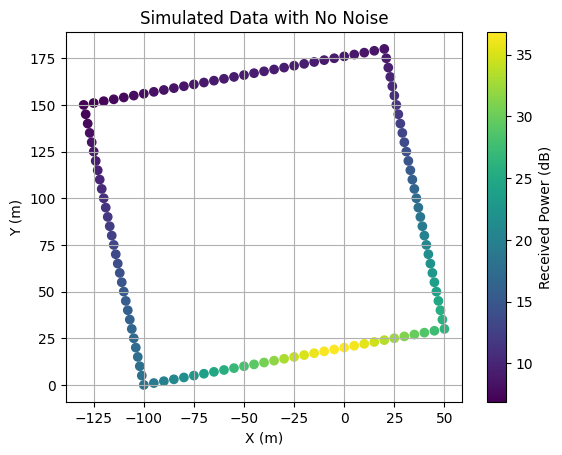

In [3]:
time_per_leg = 30
# dx, dy, dz velocity per leg
path_velocities = [[5, 1, 0],
        [-1, 5, 0],
        [-5, -1, 0],
        [1, -5, 0]]
transmitter_coordinates = (0, 0, 0)
transmitter_power = 100
simulated_power_order = 4
receiver_loss = 1

transmitter_location = np.array([transmitter_coordinates[0], transmitter_coordinates[1], 0])
drone_start_location = np.array([transmitter_coordinates[0] - 100, transmitter_coordinates[1], 30])
current_location = drone_start_location
received_pings = []

for leg in path_velocities:
    for _ in range(time_per_leg):
        current_location += np.array(leg)
        distance = np.linalg.norm(transmitter_location - current_location)
        received_power = distance_to_receive_power(distance, transmitter_power - receiver_loss, simulated_power_order)
        received_pings.append([current_location[0], current_location[1], current_location[2], received_power])
simulated_D = np.array(received_pings)

fig = plt.figure()
ax = fig.add_subplot(111)

scatter = ax.scatter(simulated_D[:,0], simulated_D[:,1], c = simulated_D[:,3])
fig.colorbar(scatter, label="Received Power (dB)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_title("Simulated Data with No Noise")
ax.grid()
print(simulated_D)

To localize the transmitter, we simply take the measurements in `simulated_D` and fit them to the model in `distance_to_receive_power`

In [4]:
from scipy.optimize import least_squares


def residuals(params: np.ndarray, data: np.ndarray) -> np.ndarray:
    estimated_transmitter_x = params[0]
    estimated_transmitter_y = params[1]
    estimated_transmitter_location = np.array(
        [estimated_transmitter_x, estimated_transmitter_y, 0])

    estimated_transmitter_power = params[2]
    estimated_model_power = params[3]

    received_power = data[:, 3]
    received_locations = data[:, 0:3]

    residuals = np.zeros(len(received_power))
    for i in range(len(received_power)):
        residuals[i] = received_power[i] - distance_to_receive_power(np.linalg.norm(
            estimated_transmitter_location - received_locations[i, :]), estimated_transmitter_power, estimated_model_power)
    return residuals


initial_guess = np.array([np.mean(simulated_D[:, 0]), np.mean(simulated_D[:, 1]),
                         np.max(simulated_D[:, 3]), 4])
results = least_squares(residuals, initial_guess, kwargs={'data': simulated_D})
print(results.x)
print("Lateral error: %f" % np.linalg.norm(
    transmitter_coordinates - np.array([results.x[0], results.x[1], 0])))
print("k error: %f" %
      (transmitter_power - receiver_loss - results.x[2]))
print("n error: %f" % (simulated_power_order - results.x[3]))

[-3.50168132e-15 -4.23785308e-14  9.90000000e+01  4.00000000e+00]
Lateral error: 0.000000
k error: -0.000000
n error: -0.000000


As shown above, the estimated result is nearly identical to the simulated parameters, which should be the case, as the only source of noise here is from quantization error.

In order to accurately simulate the data from the drone, we need to add some error to the measurements.  In this case, we will add Gaussian noise to each measurement.  For the $x$ and $y$ coordinates, we will add Gaussian noise with $\mu = 0$ and $\sigma^2 = 3$.  For the $z$ coordinate, we will add Gaussian noise with $\mu = 0$ and $\sigma^2 = 0.5$.  For the $R$ measurement, we will add Gaussian noise with $\mu = 0$ and $\sigma^2 = 5$.

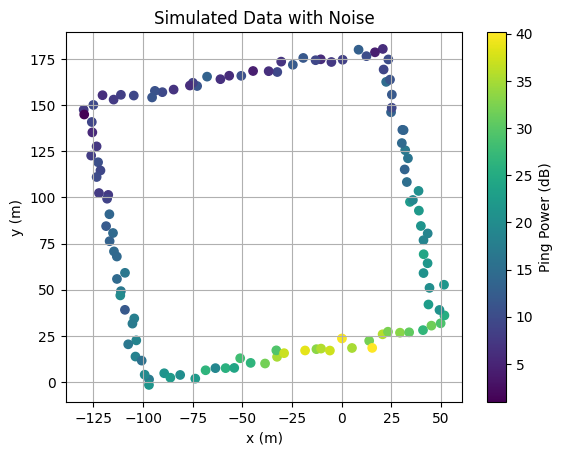

In [5]:
current_location = drone_start_location
received_pings = []
s_xy = np.sqrt(3)
s_z = np.sqrt(0.5)
s_R = np.sqrt(5)
for leg in path_velocities:
    for s in range(time_per_leg):
        current_location += np.array(leg)
        distances = np.linalg.norm(transmitter_location - current_location)
        received_power = distance_to_receive_power(distances, transmitter_power - receiver_loss, simulated_power_order)
        received_pings.append([current_location[0] + np.random.normal(0,s_xy),
                    current_location[1] + np.random.normal(0,s_xy),
                    current_location[2] + np.random.normal(0,s_z),
                    received_power + np.random.normal(0,s_R)])
simulated_D_error = np.array(received_pings)
fig = plt.figure()
ax = fig.add_subplot(111)

scatter = ax.scatter(simulated_D_error[:,0], simulated_D_error[:,1], c = simulated_D_error[:,3])
fig.colorbar(scatter, label="Ping Power (dB)")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("Simulated Data with Noise")
ax.grid()

In [6]:
initialGuess = np.array([np.mean(simulated_D_error[:,0]), np.mean(simulated_D_error[:,1]),
                         np.max(simulated_D_error[:,3]), 4])
results = least_squares(residuals, initialGuess, kwargs={'data':simulated_D_error})
print(results.x)
print("Lateral error: %f" % np.linalg.norm(transmitter_location - np.array([results.x[0], results.x[1], 0])))
print("k error: %f" % (transmitter_power - receiver_loss - results.x[2]))
print("n error: %f" % (simulated_power_order - results.x[3]))

[ 0.30631395  2.34626896 98.7730184   3.99550283]
Lateral error: 2.366180
k error: 0.226982
n error: 0.004497


# Precision Visualization

In order to provide a metric of how certain our estimate is, we need to provide a way to visualize the precision of our estimate.

## Naive Visualization

The easiest way to do this is to assume a distribution over the distance from each ping to the transmitter.  We assume that the distance calculated for each ping has additive Gaussian noise with a standard deviation of 40% of the calculated range.

Because the location of the transmitter is calculated from multiple independent measurements, the probability of the transmitter being at a particular location is equal to the product of the probability of each distance calculation.  We can then use log probability to simplify the calculations.

For a single ping, we demonstrate the probability heatmap below.  This is a simulated ping at $(0, 0)$, with a calculated distance of 50 meters.  The calculated distance is represented by the red circle, and the ping location is represented by the red triangle.

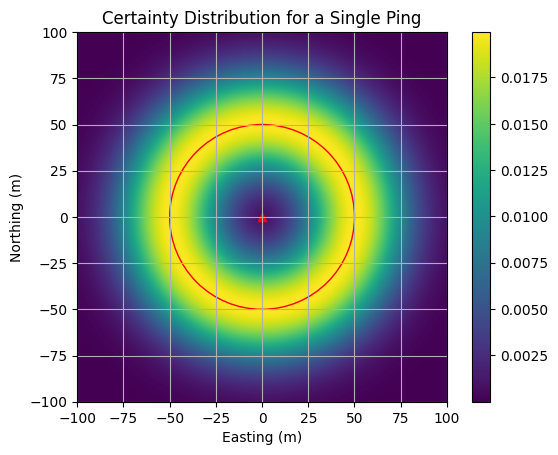

In [7]:
from scipy import stats as st
width = 100
dist = 50

field = np.zeros((2 * width, 2 * width))
origin = np.array([width, width])
stddev = 0.4 * dist
mean = dist

random_variable = st.norm(loc = mean, scale = stddev)
for x in range(field.shape[0]):
    for y in range(field.shape[1]):
        r = np.linalg.norm(np.array([x, y]) - origin)
        field[x, y] = random_variable.pdf(r)

fig = plt.figure()
ax = fig.add_subplot(111)
img = ax.imshow(field, extent=(-width, width, -width, width), origin='lower')
fig.colorbar(img)
ax.scatter(0, 0, marker='^', color='red')
cir = plt.Circle((0, 0), radius=dist, fill=False, edgecolor='red')
ax.add_artist(cir)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_title('Certainty Distribution for a Single Ping')
ax.grid()

For multiple pings, we simply sum the log probability together.  The below code simulates three pings, one at $(-50, 0)$, one at $(0, -50)$, and one at $(35, 35)$.  Each has a calculated distance of 50 meters, with the distance again represented by the red circles, and ping locations represented by the red triangles.

Text(0.5, 1.0, 'Certainty Distribution for a Three Pings')

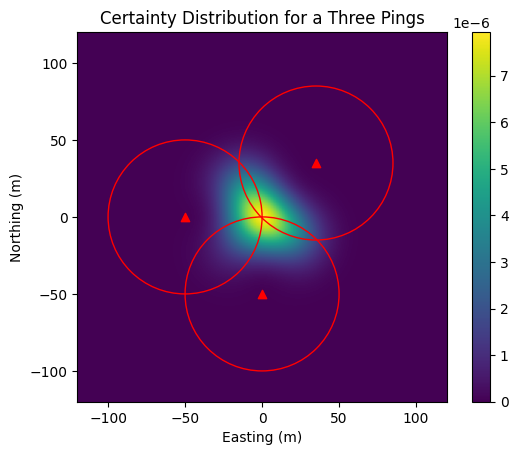

In [8]:
width = 120
dist = 50
pings = [np.array([-dist, 0]), np.array([0, -dist]), np.array([.7*dist, .7*dist])]

field = np.zeros((2 * width, 2 * width))
origin = np.array([width, width])
stddev = 0.4 * dist
mean = dist

random_variable = st.norm(loc = mean, scale = stddev)
for x in range(field.shape[0]):
    for y in range(field.shape[1]):
        for ping in pings:
            r = np.linalg.norm(np.array([x, y]) - origin - ping)
            field[x, y] += np.log10(random_variable.pdf(r))

fig = plt.figure()
ax = fig.add_subplot(111)
img = ax.imshow(np.power(10, field), extent=(-width, width, -width, width), origin='lower')
fig.colorbar(img)
for ping in pings:
    plt.scatter(ping[0], ping[1], marker='^', color='red')
    cir = plt.Circle(ping, radius=dist, fill=False, edgecolor='red')
    ax.add_artist(cir)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_title('Certainty Distribution for a Three Pings')

In order to generate a heatmap for a dataset, we need to first determine the appropriate heatmap area.  As a prerequisite, we must know the estimated transmitter location and ping locations.  Because the transmitter location might not be within the polygon that encloses all the ping locations, it is essential to take the transmitter location into account when generating the heatmap area.  A simple way to do this would be to take the maximum extents of both estimated transmitter and ping locations.  We can then use the same technique as above to generate the heatmap.

In order to generate the distances from the data, we need to invert the receive power model, which becomes $d = 10^\frac{k - R}{10n}$

In [9]:
def distance_power_model(R, k, n):
    return np.power(10, (k - R) / (10 * n))


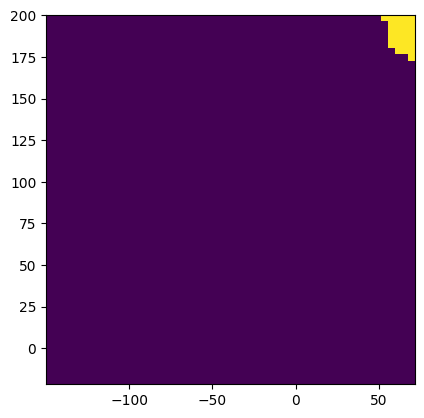

In [10]:
simulated_D_error
new_D = simulated_D_error[simulated_D_error[:,3] > 20,:]
tx_loc = results.x[0:2]
n = results.x[3]
k = results.x[2]

resolution = 0.25 # px per meter
border = 20 # meter
max_x = max(np.max(simulated_D_error[:,0]), tx_loc[0]) + border
min_x = min(np.min(simulated_D_error[:,0]), tx_loc[0]) - border
max_y = max(np.max(simulated_D_error[:,1]), tx_loc[1]) + border
min_y = min(np.min(simulated_D_error[:,1]), tx_loc[1]) - border

# origin is top left, 0.5 px / m resolution
field = np.zeros((int((max_x - min_x) * resolution), int((max_y - min_y) * resolution)))
origin = np.array([max_x, min_y])
means = [distance_power_model(R, k, n) for R in new_D[:,3]]
rv = [st.norm(loc = d, scale = 0.4 * d) for d in means]
for x in range(field.shape[0]):
    for y in range(field.shape[1]):
        px_loc = origin + np.array([-x, y]) / resolution
        for ping_idx in range(len(rv)):
            distance = np.linalg.norm(px_loc - new_D[ping_idx,0:2])
            if distance < 2 * means[ping_idx]:
                field[x, y] += np.log10(rv[ping_idx].pdf(distance))

fig = plt.figure()         
ax = fig.add_subplot(111)
ax.imshow(np.power(10, field), extent=(min_x, max_x, min_y, max_y), origin="lower")

In [11]:
tx_loc

array([0.30631395, 2.34626896])